In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

#make plots inline using jupyter magic
%matplotlib inline

import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import datasets, linear_model, metrics


import matplotlib as mpl
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
#Balanced RF Classifier
from imblearn.ensemble import BalancedRandomForestClassifier as BRF

from IPython.display import Markdown as md  #enable markdown within code cell
from IPython.display import display, Math, Latex

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix
import time
import random
import scipy

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, precision_recall_curve, make_scorer,f1_score
from sklearn.metrics import precision_recall_curve as PRC
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from numpy.fft import fftn

## Homemade code imports
import metrics

data_dir = '/run/media/mnewlin/_userdata/uhnds/'
original_netflow_data_dir = data_dir + 'network/extracted/'
original_netflow_file = 'netflow_day-02'
fake_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/fake/'
real_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/real/'
real_file = 'netflow_day-02'
# Dataset dependent number of cols
N_COLS = 20
np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [2]:
"""
    Function to read in a single real sample from a given directory based
    on the desired length of the sample.
"""
def load_real_sample(sample_num, sample_length=100):

    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1
        
    load_file = real_file + '_sample_{}.txt'.format(sample_num)
    filename = real_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.float64)
    data = np.array(df)
    return data

"""
    Function to read in a single fake sample from a given directory based
    on the desired length of the sample.
"""
def load_fake_sample(sample_num, sample_length=100):
    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1

    load_file = real_file + '_random_sample_{}.txt'.format(sample_num)
    filename = fake_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.float64)
    data = np.array(df)
    return data

def load_n_samples(real=True, sample_length=100, num_samples=100, random_state=69):
    sample_set = np.array([])
    sample_range = 0
    if sample_length <= 1000:
        sample_range = 10000
    elif sample_length <= 10000:
        sample_range = 2000
    elif sample_length <= 100000:
        sample_range = 1160
    # Seed random samples for repeatability    
    random.seed(a=random_state)
    sample_list = random.sample(range(sample_range), num_samples)
    if real:
        for num in sample_list:
            data = load_real_sample(sample_length=sample_length, sample_num=num)
            sample_set = np.append(sample_set, data)
    else:
        for num in sample_list:
            data = load_fake_sample(sample_length=sample_length, sample_num=num)
            sample_set = np.append(sample_set, data)
    sample_set = np.reshape(sample_set, newshape=(num_samples, sample_length, N_COLS))
    return sample_set

def create_sample_mix(ratio, sample_length=100, num_samples=100, random_state=69):
    sample_range = 0
    if sample_length <= 1000:
        sample_range = 10000
    elif sample_length <= 10000:
        sample_range = 2000
    elif sample_length <= 100000:
        sample_range = 1160
    
    #mix_set = np.zeros((num_samples, sample_length, N_COLS))
    bound_val_real = np.around(((1-ratio)*num_samples), decimals=2)
    bound_val_fake = np.around((ratio)*num_samples, decimals=2)
    bound_val_real = int(bound_val_real) # How many real samples there should be
    bound_val_fake = int(bound_val_fake) # How many fake samples there should be
    
    real_data = load_n_samples(real=True, num_samples=num_samples, sample_length=sample_length, random_state=random_state) 
    fake_data = load_n_samples(real=True, num_samples=num_samples, sample_length=sample_length, random_state=random_state)
    real_section = real_data[:bound_val_real]
    fake_section = fake_data[:bound_val_real]
    mix_set = np.append(real_section, fake_section)
    mix_set = np.reshape(mix_set, newshape=(num_samples, sample_length, N_COLS))
    return mix_set

"""
    Takes in a set S of shape (num_samples, sample_length, N_COLS)
    and returns the PCA transform of each sample of shape (num_samples, N_COLS, N_COLS)
"""
def pca_transform_set(S):
    pca = PCA()
    num_samples = S.shape[0]
    sample_length = S.shape[1]
    s_pca = np.zeros((num_samples, sample_length, N_COLS))
    for x in range(num_samples):
        pca.fit(S[x])
        s_pca[x] = pca.components_
    return s_pca
    

In [4]:
def load_real_host_sample(sample_num, sample_length=1000):
    directory = '/run/media/mnewlin/_userdata/uhnds/host/unconverted/real/tfidf/'
    real_host_data_dir = directory + 'samples_{}/'.format(sample_length)
        
    load_file = real_host_data_dir + 'tfidf_sample_{}.csv'.format(sample_num)
    df = pd.read_csv(load_file, dtype=np.float64)
    data = np.array(df)
    return data

def load_fake_host_sample(sample_num, sample_length=1000,dist='uniform'):
    directory = '/run/media/mnewlin/_userdata/uhnds/host/unconverted/fake/{}/'.format(dist)
    
    fake_host_data_dir = directory + 'samples_{}/'.format(sample_length)
        
    load_file = fake_host_data_dir + 'tfidf_sample_{}.csv'.format(sample_num)
    df = pd.read_csv(load_file, dtype=np.float64)
    data = np.array(df)
    return data

def load_n_host_samples(real=True, sample_length=100, num_samples=100, random_state=69, dist='uniform'):

    sample_set = np.array([])
    sample_range= 10000
    random.seed(a=random_state)
    sample_list = random.sample(range(sample_range), num_samples)
    if real:
        for num in sample_list:
            data = load_real_host_sample(sample_length=sample_length, sample_num=num)
            sample_set = np.append(sample_set, data)
    else:
        for num in sample_list:
            data = None
            if dist == 'uniform':
                data = load_fake_host_sample(sample_length=sample_length, sample_num=num, dist='uniform')
            else:
                data = load_fake_host_sample(sample_length=sample_length, sample_num=num, dist='normal')
            sample_set = np.append(sample_set, data)
    sample_set = np.reshape(sample_set, newshape=(num_samples, sample_length, N_COLS))
        
    return sample_set

## Time Efficiency

In [8]:
num_sample_list = [5*(n+1)*100 for n in range(20)]
num_sample_list.insert(0,100)
print(num_sample_list)
num_metrics = 11
num_sample_list = np.array(num_sample_list)
time_list = np.zeros((num_sample_list.size))
time_data_all = np.zeros((num_sample_list.size, num_metrics+1))
time_data_all[:,0] = num_sample_list
names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd', 'fid']
cols = ['Runtime: ' + x for x in names]
cols.insert(0,'Number of Samples')


sample_length = 1000

[100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]


In [9]:

for i in range(num_sample_list.size):
    sample_set_size = num_sample_list[i]
    S1 = load_n_host_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=69, dist='uniform')
    S2 = load_n_host_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=42, dist='uniform')
    G1 = load_n_host_samples(real=False, sample_length=sample_length, num_samples=sample_set_size, random_state=69, dist='uniform')
    G2 = load_n_host_samples(real=False, sample_length=sample_length, num_samples=sample_set_size, random_state=42, dist='uniform')
    
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='lp', p=2, r=2)
    time_data_all[i,1] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='lp', p=1, r=1)
    time_data_all[i,2] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='lp', p=0.5, r=0.5)
    time_data_all[i,3] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='lp', p=0.75, r=0.75)
    time_data_all[i,4] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='cosine')
    time_data_all[i,5] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='mahalanobis')
    time_data_all[i,6] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='wasserstein')
    time_data_all[i,7] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='entropy', standardized=False)
    time_data_all[i,8] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='perplexity', standardized=False)
    time_data_all[i,9] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='mmd', G1=G1, G2=G2)
    time_data_all[i,10] = t_diff
    
    pca = PCA()
    real_set_1 = np.zeros((sample_set_size, N_COLS, N_COLS))
    real_set_2 = np.zeros((sample_set_size, N_COLS, N_COLS))
    for x in range(sample_set_size):
        pca.fit(S1[x])
        real_set_1[x] = pca.components_
        
        pca.fit(S2[x])
        real_set_2[x] = pca.components_
    _,t_diff = metrics.time_score_set(S1=real_set_1, S2=real_set_2, sample_length=N_COLS, num_samples=sample_set_size, metric='fid')
    time_data_all[i,11] = t_diff
    print(sample_set_size)
time_eff_df = pd.DataFrame(data=time_data_all, columns=cols)
print("Finished")
display(time_eff_df.head())


100
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
Finished


,Number of Samples,Runtime: Euclidean,Runtime: Manhattan,Runtime: lp: p=r=0.5,Runtime: lp: p=r=0.75,Runtime: cosine,Runtime: mahalanobis,Runtime: wasserstein,Runtime: entropy,Runtime: perplexity,Runtime: mmd,Runtime: fid
0,100.0,0.097201,0.108575,0.233952,0.213666,0.244991,21.678632,0.565443,1.624450,1.323655,5.477052,0.763395
1,500.0,0.518569,0.552779,1.201922,1.125354,0.911012,107.212674,3.082426,7.408498,10.494967,39.505104,3.610181
2,1000.0,1.136816,1.061966,2.253606,2.229029,1.859999,214.363126,4.527078,17.863301,15.307363,68.691054,6.944791
3,1500.0,1.523893,1.406959,3.526288,3.152235,3.176596,316.188397,7.871027,22.966104,24.232187,81.560157,12.572431
4,2000.0,2.325309,1.685861,4.577591,3.533738,3.461321,425.166521,10.061076,29.834790,31.819123,106.645622,14.048424


In [15]:
#outfile='/home/mnewlin/git/AFIT/Thesis/code/results/time_efficiency_results.csv'
#time_eff_df.to_csv(outfile)
"""
wass_diffs = np.zeros((num_sample_list.size,))
for i in range(num_sample_list.size):
    sample_set_size = num_sample_list[i]
    S1 = load_n_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=69)
    S2 = load_n_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=42)
    _, wass_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='wasserstein')
    wass_diffs[i] = wass_diff
    print(sample_set_size, wass_diff)
print("Finished")
"""

100 0.3096740245819092
500 1.2164556980133057
1000 2.453577995300293
1500 3.6714236736297607
2000 4.872739553451538
2500 6.1920082569122314
3000 7.315247297286987
3500 8.446828842163086
4000 9.519686937332153
4500 10.84392261505127
5000 11.98257565498352
5500 13.231746912002563
6000 14.595314979553223
6500 15.757635354995728
7000 17.01756000518799
7500 18.00524592399597
8000 19.447341918945312
8500 20.329765558242798
9000 22.04736089706421
9500 22.900646209716797
10000 24.028891563415527
Finished


'\nsample_set_size = 1000\nS1 = load_n_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=69)\nS2 = load_n_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=42)\nts = time.time()\nfor i in range(sample_set_size):\n    metrics.wasserstein_dist(S1[i], S2[i])\nte = time.time()\nt_diff = te-ts\nprint(t_diff)\n'

In [17]:
#time_eff_df.at[:,'Runtime: wasserstein'] = wass_diffs
#display(time_eff_df.head())

,Number of Samples,Runtime: Euclidean,Runtime: Manhattan,Runtime: lp: p=r=0.5,Runtime: lp: p=r=0.75,Runtime: cosine,Runtime: mahalanobis,Runtime: wasserstein,Runtime: entropy,Runtime: perplexity,Runtime: mmd,Runtime: fid
0,100.0,0.042104,0.041378,0.093954,0.091635,0.089536,6.483543,0.309674,0.643925,0.635140,8.592701,0.366710
1,500.0,0.211824,0.191801,0.412017,0.441723,0.429452,37.315845,1.216456,3.171206,3.298879,46.080745,1.620127
2,1000.0,0.417698,0.414131,0.853007,0.876126,0.882164,71.234659,2.453578,6.327049,6.315486,88.930807,3.303151
3,1500.0,0.592239,0.572699,1.272341,1.282392,1.258052,106.159819,3.671424,9.341181,9.416537,133.281123,4.913507
4,2000.0,0.863315,0.772867,1.686367,1.722260,1.702844,140.371236,4.872740,12.451819,12.395903,178.559145,6.679852


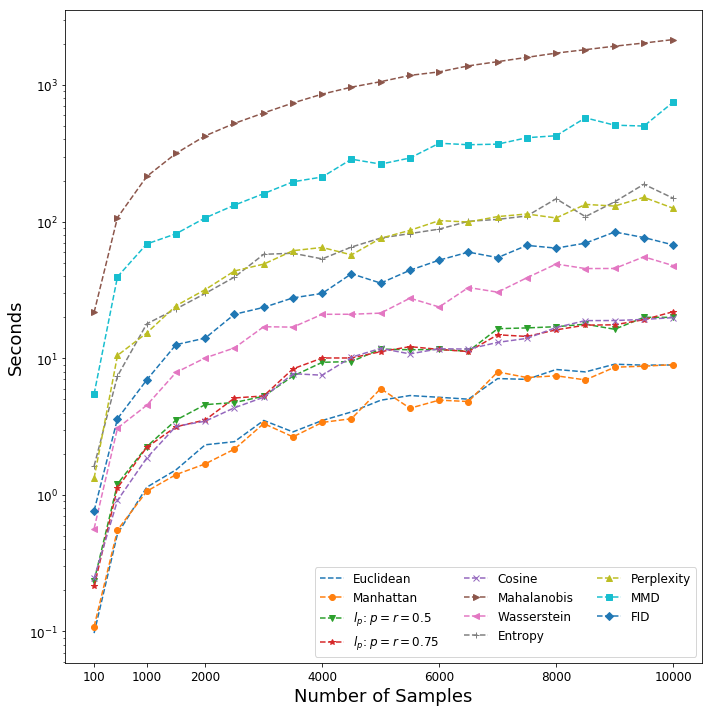

In [10]:
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
num_metrics = len(names)
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    plt.semilogy(time_eff_df.loc[:,'Number of Samples'], time_eff_df.iloc[:,i+1], markers[i], label=names[i])
plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("Seconds", fontsize=18)
plt.xticks([100, 1000, 2000, 4000, 6000, 8000, 10000], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, ncol=3)
plt.tight_layout()
plt.savefig('figures/efficiency/eps/host/time_efficiency_host.eps')
plt.savefig('figures/efficiency/png/host/time_efficiency_host.png')
plt.show()
    
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/time_efficiency_host_results.csv'
time_eff_df.to_csv(outfile)

## Sample Efficiency

### Untransformed Data

In [28]:
num_metrics = 10
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
counter = 0
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/home/mnewlin/git/AFIT/Thesis/code/results/untrans/'
    real_data_untrans = pd.read_csv(indir+'real_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(real_data_untrans.head())
    fake_data_untrans = pd.read_csv(indir+'fake_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_untrans
    fake_data = fake_data_untrans
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 5
        grid_y = 2
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd 
        plt.close()
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5
    #KLD_data_all = np.zeros((num_metrics, n_repeats))
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)

    kld_data = np.array([euc_KLD, man_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    sample_efficiency_results[0,:,counter] = kld_data
    #sample_efficiency_results[1,:,counter] = KLD_data_untrans.loc[:,'Std. Dev.']
    counter += 1    
    #KLD_data_all[:,i] = kld_data.T
    

In [12]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)
#sample_eff_res_std_df = pd.DataFrame(data=sample_efficiency_results[1], index=names, columns=num_sample_list)
#display(sample_eff_res_std_df)

,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,1.028608,1.462387,1.401442,1.361445,1.443913,1.601041,1.542161,1.781100,1.662989,1.763350,2.058552
Manhattan,0.281119,0.184771,0.183477,0.158969,0.146232,0.185034,0.192233,0.192628,0.207448,0.221786,0.226754
lp: p=r=0.5,3.262993,5.514094,6.237230,5.376670,6.018569,5.950881,6.137729,6.453533,6.505108,6.554041,7.448333
lp: p=r=0.75,1.876092,3.065363,3.313591,3.150628,3.116033,3.172940,3.148753,3.384921,3.405356,3.583583,4.311180
cosine,6.343285,3.547180,3.463929,2.817403,2.637750,2.667019,2.826259,2.601064,2.957623,2.844301,3.101281
mahalanobis,7.326701,6.465480,6.435184,5.320477,5.404024,4.672071,3.994273,4.075488,3.588145,3.410801,2.986658
wasserstein,8.765616,8.840091,8.890730,8.905870,8.912438,8.918579,8.940733,8.942380,8.947463,8.945541,8.963983
entropy,3.094676,3.259197,3.389493,3.194702,3.238249,3.210822,3.140931,3.159152,3.148540,3.268730,3.267573
perplexity,4.846237,4.719260,4.709215,4.511347,4.354355,4.228685,4.190444,4.041028,3.922029,4.300913,4.171530
mmd,0.081689,0.022573,0.020556,0.011604,0.008661,0.006272,0.006901,0.004972,0.004379,0.004657,0.004299


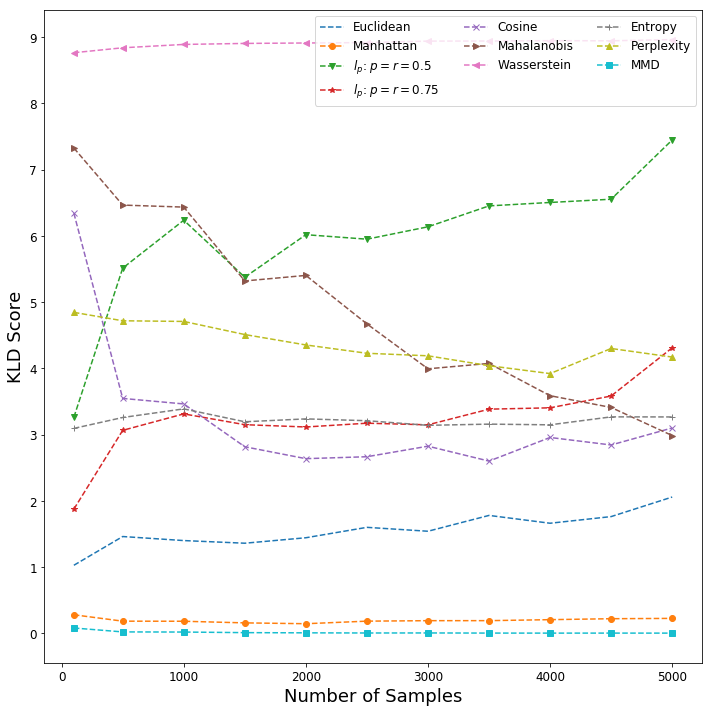

In [13]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
"""
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=sample_eff_res_mean_df.index[i])
    plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0,9, 10), fontsize=12)
plt.legend(fontsize=12, ncol=3)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_untrans_std.pdf')
plt.savefig(outdir + 'png/sample_efficiency_untrans_std.png')
plt.show()
"""
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(fontsize=12, ncol=3)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_untrans.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_untrans.png')
plt.show()

## Square Root

In [14]:
num_metrics = 10
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
counter = 0
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/home/mnewlin/git/AFIT/Thesis/code/results/sqrt/'
    real_data_sqrt = pd.read_csv(indir+'real_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(real_data_untrans.head())
    fake_data_sqrt = pd.read_csv(indir+'fake_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_sqrt
    fake_data = fake_data_sqrt
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 5
        grid_y = 2
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd 
        plt.close()
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)

    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    sample_efficiency_results[0,:,counter] = kld_data
    #sample_efficiency_results[1,:,counter] = KLD_data_untrans.loc[:,'Std. Dev.']
    counter += 1
    

In [15]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)


,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,1.610483,1.455287,1.960035,1.480909,1.534661,1.652480,1.530755,1.565944,1.447473,1.438141,1.624141
Manhattan,2.586051,3.238609,3.732516,2.954011,3.555982,3.508118,3.583950,3.444363,3.619526,3.590725,4.116898
lp: p=r=0.5,4.138551,6.674339,7.021430,6.050572,6.329364,6.545431,6.411707,6.391871,6.501691,6.694645,7.774542
lp: p=r=0.75,3.182864,4.891018,4.690404,3.955134,4.787589,4.972466,4.951483,4.863459,4.964488,5.098543,5.948881
cosine,5.325244,2.703113,2.577926,2.308356,2.343024,2.180107,2.267244,2.439841,2.584976,2.618465,2.806652
mahalanobis,7.331707,6.486819,6.453379,5.398148,5.464629,4.742698,4.076562,4.146388,3.648510,3.475567,3.041433
wasserstein,8.527651,8.607051,8.674708,8.693248,8.698584,8.715363,8.741930,8.741114,8.738796,8.743297,8.762847
entropy,2.022561,2.051564,2.027549,2.034041,2.021996,1.997771,2.025464,1.960083,1.906804,2.030539,1.980342
perplexity,2.607807,2.327783,2.568214,2.419729,2.335249,2.210524,2.189174,2.095235,1.996961,2.114406,1.978463
mmd,0.134721,0.028383,0.020391,0.013878,0.013104,0.011348,0.010026,0.008865,0.008585,0.008793,0.008073


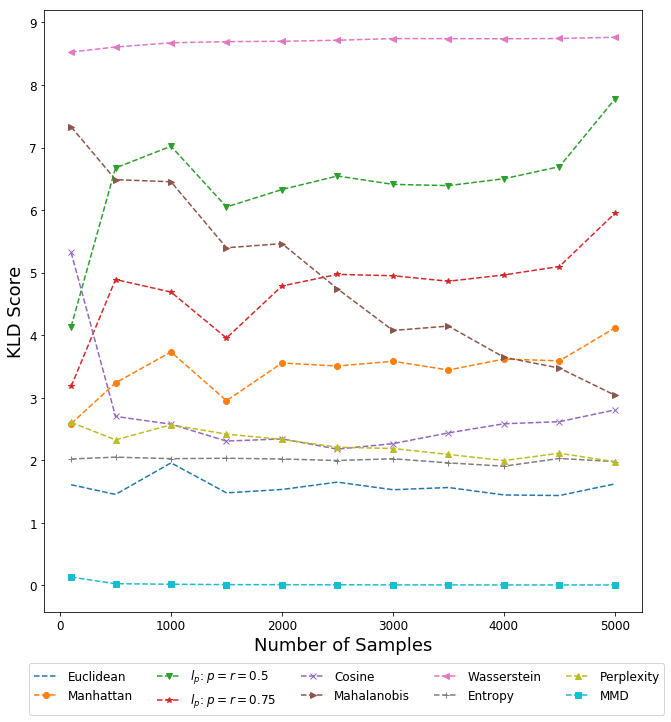

In [16]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
"""
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=sample_eff_res_mean_df.index[i])
    plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0,6, 7), fontsize=12)
plt.legend(fontsize=12, ncol=3)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_sqrt_std.pdf')
plt.savefig(outdir + 'png/sample_efficiency_sqrt_std.png')
plt.show()
"""
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(loc=(-0.025,-.17), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_sqrt.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_sqrt.png')
plt.show()

## Log

In [17]:
num_metrics = 10
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
counter = 0
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/home/mnewlin/git/AFIT/Thesis/code/results/log/'
    real_data_log = pd.read_csv(indir+'real_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(real_data_untrans.head())
    fake_data_log = pd.read_csv(indir+'fake_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_log
    fake_data = fake_data_log
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 5
        grid_y = 2
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd 
        plt.close()
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)

    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    sample_efficiency_results[0,:,counter] = kld_data
    #sample_efficiency_results[1,:,counter] = KLD_data_untrans.loc[:,'Std. Dev.']
    counter += 1
print("Finished")   

Finished


In [18]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)


,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,0.439371,0.289568,0.261281,0.223520,0.228330,0.276137,0.270004,0.303303,0.298655,0.332811,0.358099
Manhattan,1.151994,1.518115,1.873437,1.701626,1.629963,1.737911,1.716390,2.148332,1.816744,2.059353,2.425681
lp: p=r=0.5,3.548704,5.792412,6.475737,5.492863,6.126817,6.121796,6.227779,6.584520,6.631376,6.649580,7.561553
lp: p=r=0.75,2.099682,3.039021,3.833422,3.458778,3.394957,3.406589,3.306403,3.662811,3.589103,3.919190,4.684513
cosine,6.206896,3.282211,3.245811,2.668287,2.454930,2.483656,2.592409,2.479594,2.806077,2.715971,2.962474
mahalanobis,7.326509,6.463577,6.442108,5.348606,5.413959,4.677032,4.011689,4.087900,3.594275,3.427876,2.984801
wasserstein,8.801951,8.883176,8.938114,8.957526,8.962479,8.970162,8.993178,8.992970,8.993640,8.992756,9.010160
entropy,2.779175,2.914254,3.002188,2.836001,2.896238,2.866334,2.796082,2.829141,2.817662,2.867976,2.882450
perplexity,4.419704,4.422302,4.401828,4.086154,3.987152,3.825737,3.741992,3.637461,3.489580,3.726258,3.613899
mmd,0.088007,0.028066,0.016318,0.009762,0.007329,0.007267,0.006273,0.005671,0.005559,0.005635,0.004947


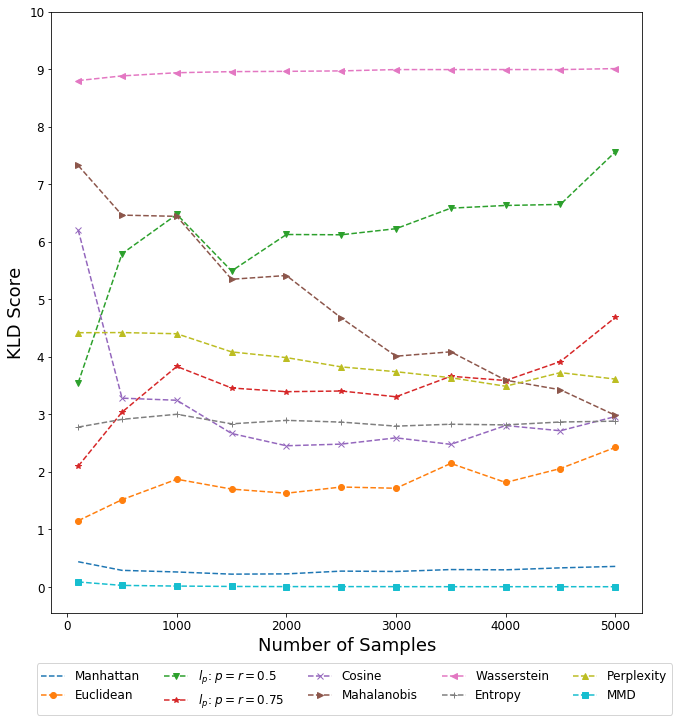

In [20]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
"""
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=sample_eff_res_mean_df.index[i])
    plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(fontsize=12, ncol=3)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_log_std.pdf')
plt.savefig(outdir + 'png/sample_efficiency_log_std.png')
plt.show()
"""
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(loc=(-0.025,-.17), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_log.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_log.png')
plt.show()

## PCA

In [21]:
num_metrics = 11
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
counter = 0
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/home/mnewlin/git/AFIT/Thesis/code/results/pca/'
    real_data_pca = pd.read_csv(indir+'real_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0'], axis=1)
    #display(real_data_untrans.head())
    fake_data_pca = pd.read_csv(indir+'fake_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 
              'Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_pca
    fake_data = fake_data_pca
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 4
        grid_y = 3
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
                if count >= num_metrics:
                    break
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd
        plt.close()
        
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd', 'fid']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5    
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)
    fid_KLD = metrics.KL(real_data.loc[:,'fid']/np.sum(real_data.loc[:,'fid']), fake_data.loc[:,'fid']/np.sum(fake_data.loc[:,'fid']), eps=eps)
    
    kld_data = np.array([euc_KLD, man_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD, fid_KLD])
    sample_efficiency_results[0,:,counter] = kld_data
    #sample_efficiency_results[1,:,counter] = KLD_data_untrans.loc[:,'Std. Dev.']
    counter += 1
print("Finished")

Finished


In [22]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)


,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,7.561798,7.515871,7.557169,7.480202,7.536159,7.531362,7.578437,7.512969,7.665623,7.621085,7.742283
Manhattan,2.886752,2.436708,2.496194,2.144939,2.207131,1.891644,1.698601,1.901351,1.724827,1.565439,1.620190
lp: p=r=0.5,7.665635,7.561898,7.573436,7.493403,7.500101,7.488860,7.535842,7.511488,7.604376,7.593211,7.716610
lp: p=r=0.75,7.616681,7.551843,7.572470,7.497350,7.525713,7.514679,7.560662,7.526611,7.638384,7.610379,7.728232
cosine,3.799464,3.739015,3.681736,3.743986,3.673115,3.746370,3.694565,3.545639,3.613925,3.664390,3.708640
mahalanobis,3.186080,2.686055,2.916762,2.370935,2.508166,2.209771,1.939853,1.997972,1.689330,1.763042,1.534982
wasserstein,7.958211,6.709239,6.793738,6.686171,6.576329,6.805074,7.003581,6.962251,7.303063,7.222818,7.608641
entropy,8.262377,8.229678,8.248193,8.218564,8.234349,8.219974,8.207327,8.206402,8.218533,8.230864,8.255997
perplexity,7.956245,7.904478,7.924863,7.884329,7.909865,7.881629,7.889721,7.885695,7.899845,7.927460,7.954920
mmd,2.435751,1.631389,1.680739,1.545987,1.560716,1.572440,1.644907,1.636342,1.737448,1.727858,1.856062


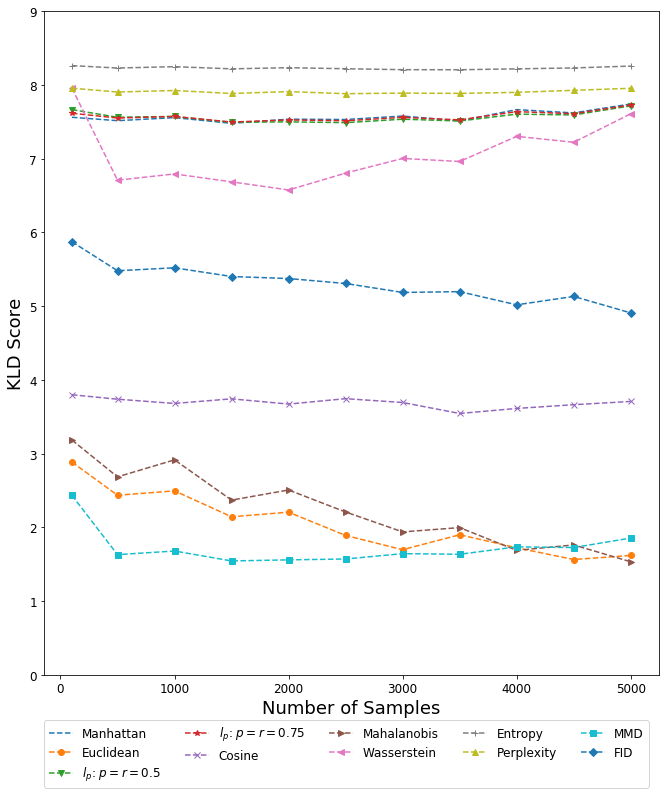

In [23]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
"""
fig = plt.figure(figsize=(10,11))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=sample_eff_res_mean_df.index[i])
    plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )


plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(loc=(0,-.17), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_pca_std.pdf')
plt.savefig(outdir + 'png/sample_efficiency_pca_std.png')
plt.show()
"""
fig = plt.figure(figsize=(10,11))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(loc=(0,-.17), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_pca.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_pca.png')
plt.show()

## FFT

In [24]:
num_metrics = 10
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
counter = 0
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/home/mnewlin/git/AFIT/Thesis/code/results/fft/'
    real_data_fft = pd.read_csv(indir+'real_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(real_data_untrans.head())
    fake_data_fft = pd.read_csv(indir+'fake_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_fft
    fake_data = fake_data_fft
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 5
        grid_y = 2
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd 
        plt.close()
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-3
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)

    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    sample_efficiency_results[0,:,counter] = kld_data
    #sample_efficiency_results[1,:,counter] = KLD_data_untrans.loc[:,'Std. Dev.']
    counter += 1
print("Finished")    

Finished


In [25]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)

,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,2.713658,2.958379,3.103755,2.970717,3.286354,3.292061,3.408996,3.371049,3.224519,3.388158,3.186210
Manhattan,0.147687,0.102272,0.099671,0.112503,0.074386,0.079612,0.084217,0.073946,0.064071,0.069768,0.066729
lp: p=r=0.5,0.148975,0.080928,0.081557,0.071122,0.065553,0.060492,0.042065,0.043699,0.037116,0.043293,0.038861
lp: p=r=0.75,0.168520,0.123145,0.104480,0.099810,0.090700,0.095508,0.091387,0.092394,0.077442,0.085526,0.079508
cosine,3.146211,3.136945,3.174215,3.166839,3.191542,3.180987,3.165329,3.209605,3.220575,3.201709,3.291627
mahalanobis,2.868976,2.692874,2.797620,2.610603,2.675982,2.679106,2.573964,2.503609,2.472970,2.494354,2.534601
wasserstein,2.653683,2.089704,2.064752,2.107573,2.204192,2.414174,2.408554,2.458014,2.675785,2.579862,2.824714
entropy,3.571969,3.578096,3.586222,3.587618,3.589346,3.588904,3.587243,3.597429,3.599923,3.602444,3.593246
perplexity,2.914297,2.911635,2.917797,2.921765,2.923492,2.925321,2.924735,2.930333,2.932000,2.933504,2.933961
mmd,0.684055,0.593245,0.583870,0.558561,0.518415,0.482340,0.503345,0.544736,0.575110,0.551843,0.601499


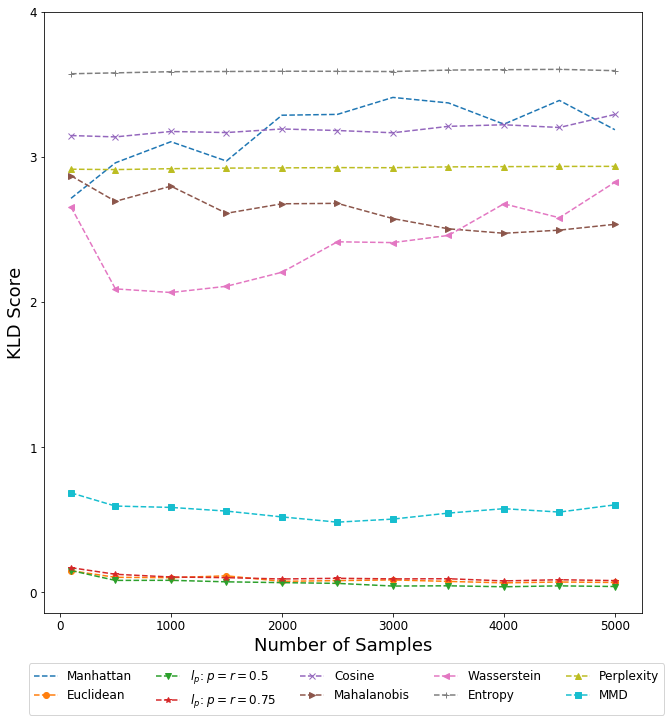

In [26]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
"""
fig = plt.figure(figsize=(10,10))

for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=sample_eff_res_mean_df.index[i])
    plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )


plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(fontsize=12, ncol=3)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_fft_std.pdf')
plt.savefig(outdir + 'png/sample_efficiency_fft_std.png')
plt.show()
"""
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(loc=(-0.025,-.17), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_fft.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_fft.png')
plt.show()

## Alternate Approach

## Untransformed

In [149]:
num_metrics = 10
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
score_gap_real = np.zeros((len(num_sample_list), num_metrics))
score_gap_fake = np.zeros((len(num_sample_list), num_metrics))
score_gap_real_std = np.zeros((len(num_sample_list), num_metrics))
score_gap_fake_std = np.zeros((len(num_sample_list), num_metrics))
counter = 0
for x in num_sample_list:
    indir = '/home/mnewlin/git/AFIT/Thesis/code/results/untrans/'
    real_data_untrans = pd.read_csv(indir+'real_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(real_data_untrans.head())
    fake_data_untrans = pd.read_csv(indir+'fake_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    score_gap_real[counter] = real_data_untrans.mean(axis=0)
    score_gap_real_std[counter] = real_data_untrans.std(axis=0)
    score_gap_fake[counter] = fake_data_untrans.mean(axis=0)
    score_gap_fake_std[counter] = fake_data_untrans.std(axis=0)
    
    counter += 1



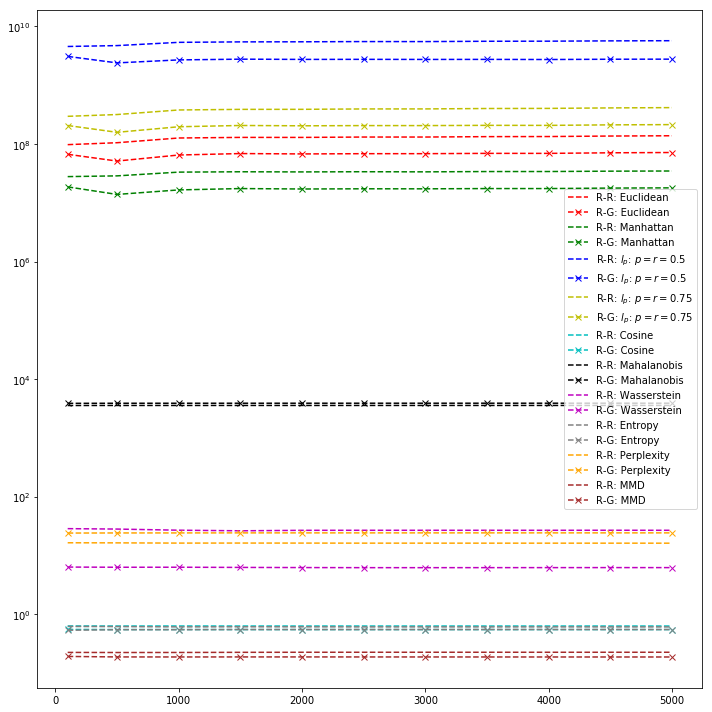

In [155]:
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
colors = ['r', 'g', 'b', 'y', 'c', 'k', 'm', 'gray', 'orange', 'brown']
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    plt.semilogy(num_sample_list, score_gap_real[:,i], '--', label='R-R: '+ names[i], color=colors[i])
    plt.semilogy(num_sample_list, score_gap_fake[:,i], '--x', label='R-G: '+ names[i], color=colors[i])
plt.tight_layout()
plt.legend()
plt.show()